In [1]:
import sys 
sys.path.append('..')
from IPython.display import Image
from recordtype import recordtype # to modify unmutable 

To control a vehicle for a given reference path, one of the important topic is to locate the car with respect to the reference path. In this kinematic control tutorial, the linear feedback control coefficients are used for the lateral and yaw deviations $(e_y, \;e_\Psi)$. 

One way to locate the car for the given reference path is to use vector projection. Assume that we are given a sequece of waypoints depicted in the following figure. 

In [2]:
figpath ='figs/'

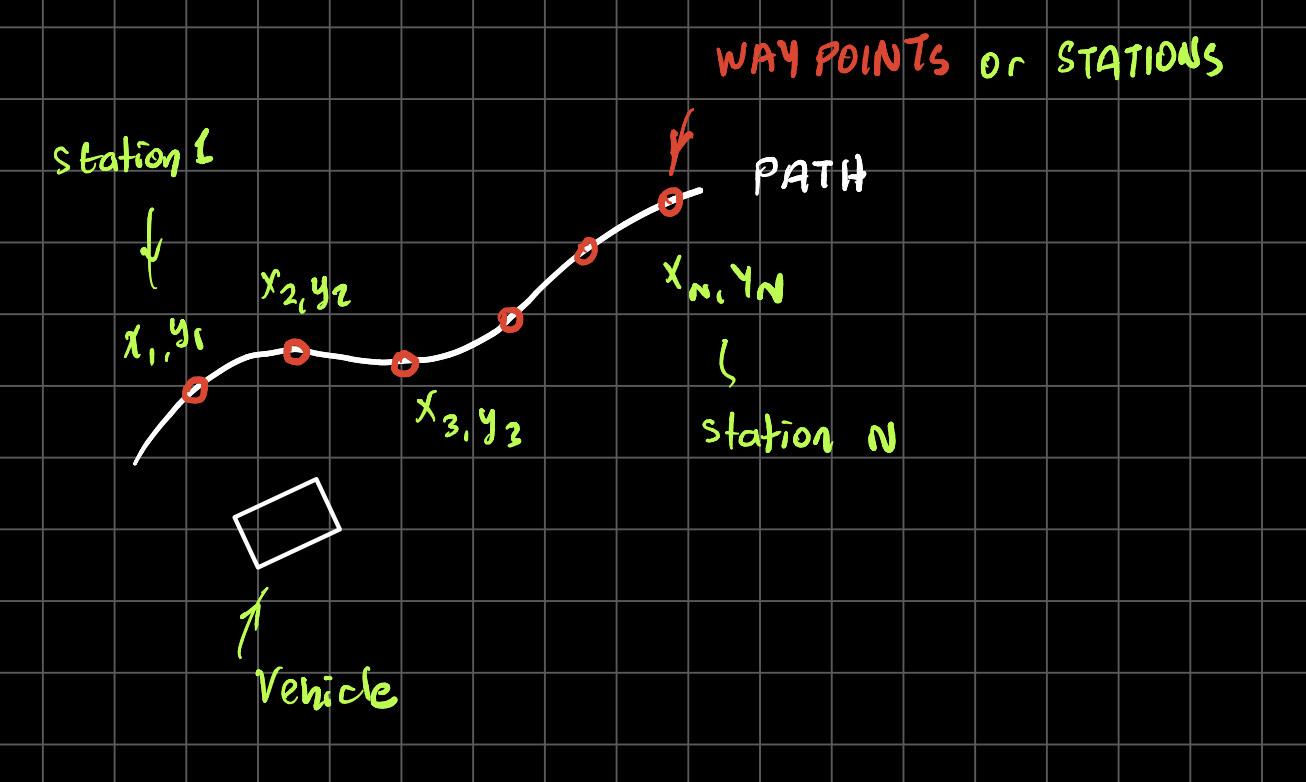

In [3]:
Image(filename=figpath+'fig_1.jpg')

In the figure above, the waypoints or stations are given. Usually only $x$ and $y$ coordinate information are sufficient. Given the reference path, we need to find an instantaneous reference point on the path to find the error deviations. To do this, first we create vectors from all the waypoints pointing to the vehicle reference point. For the kinematic controller of the paper, we use the center of the rear axle of the car. 

The procedure is demonstrated in the following figure. 

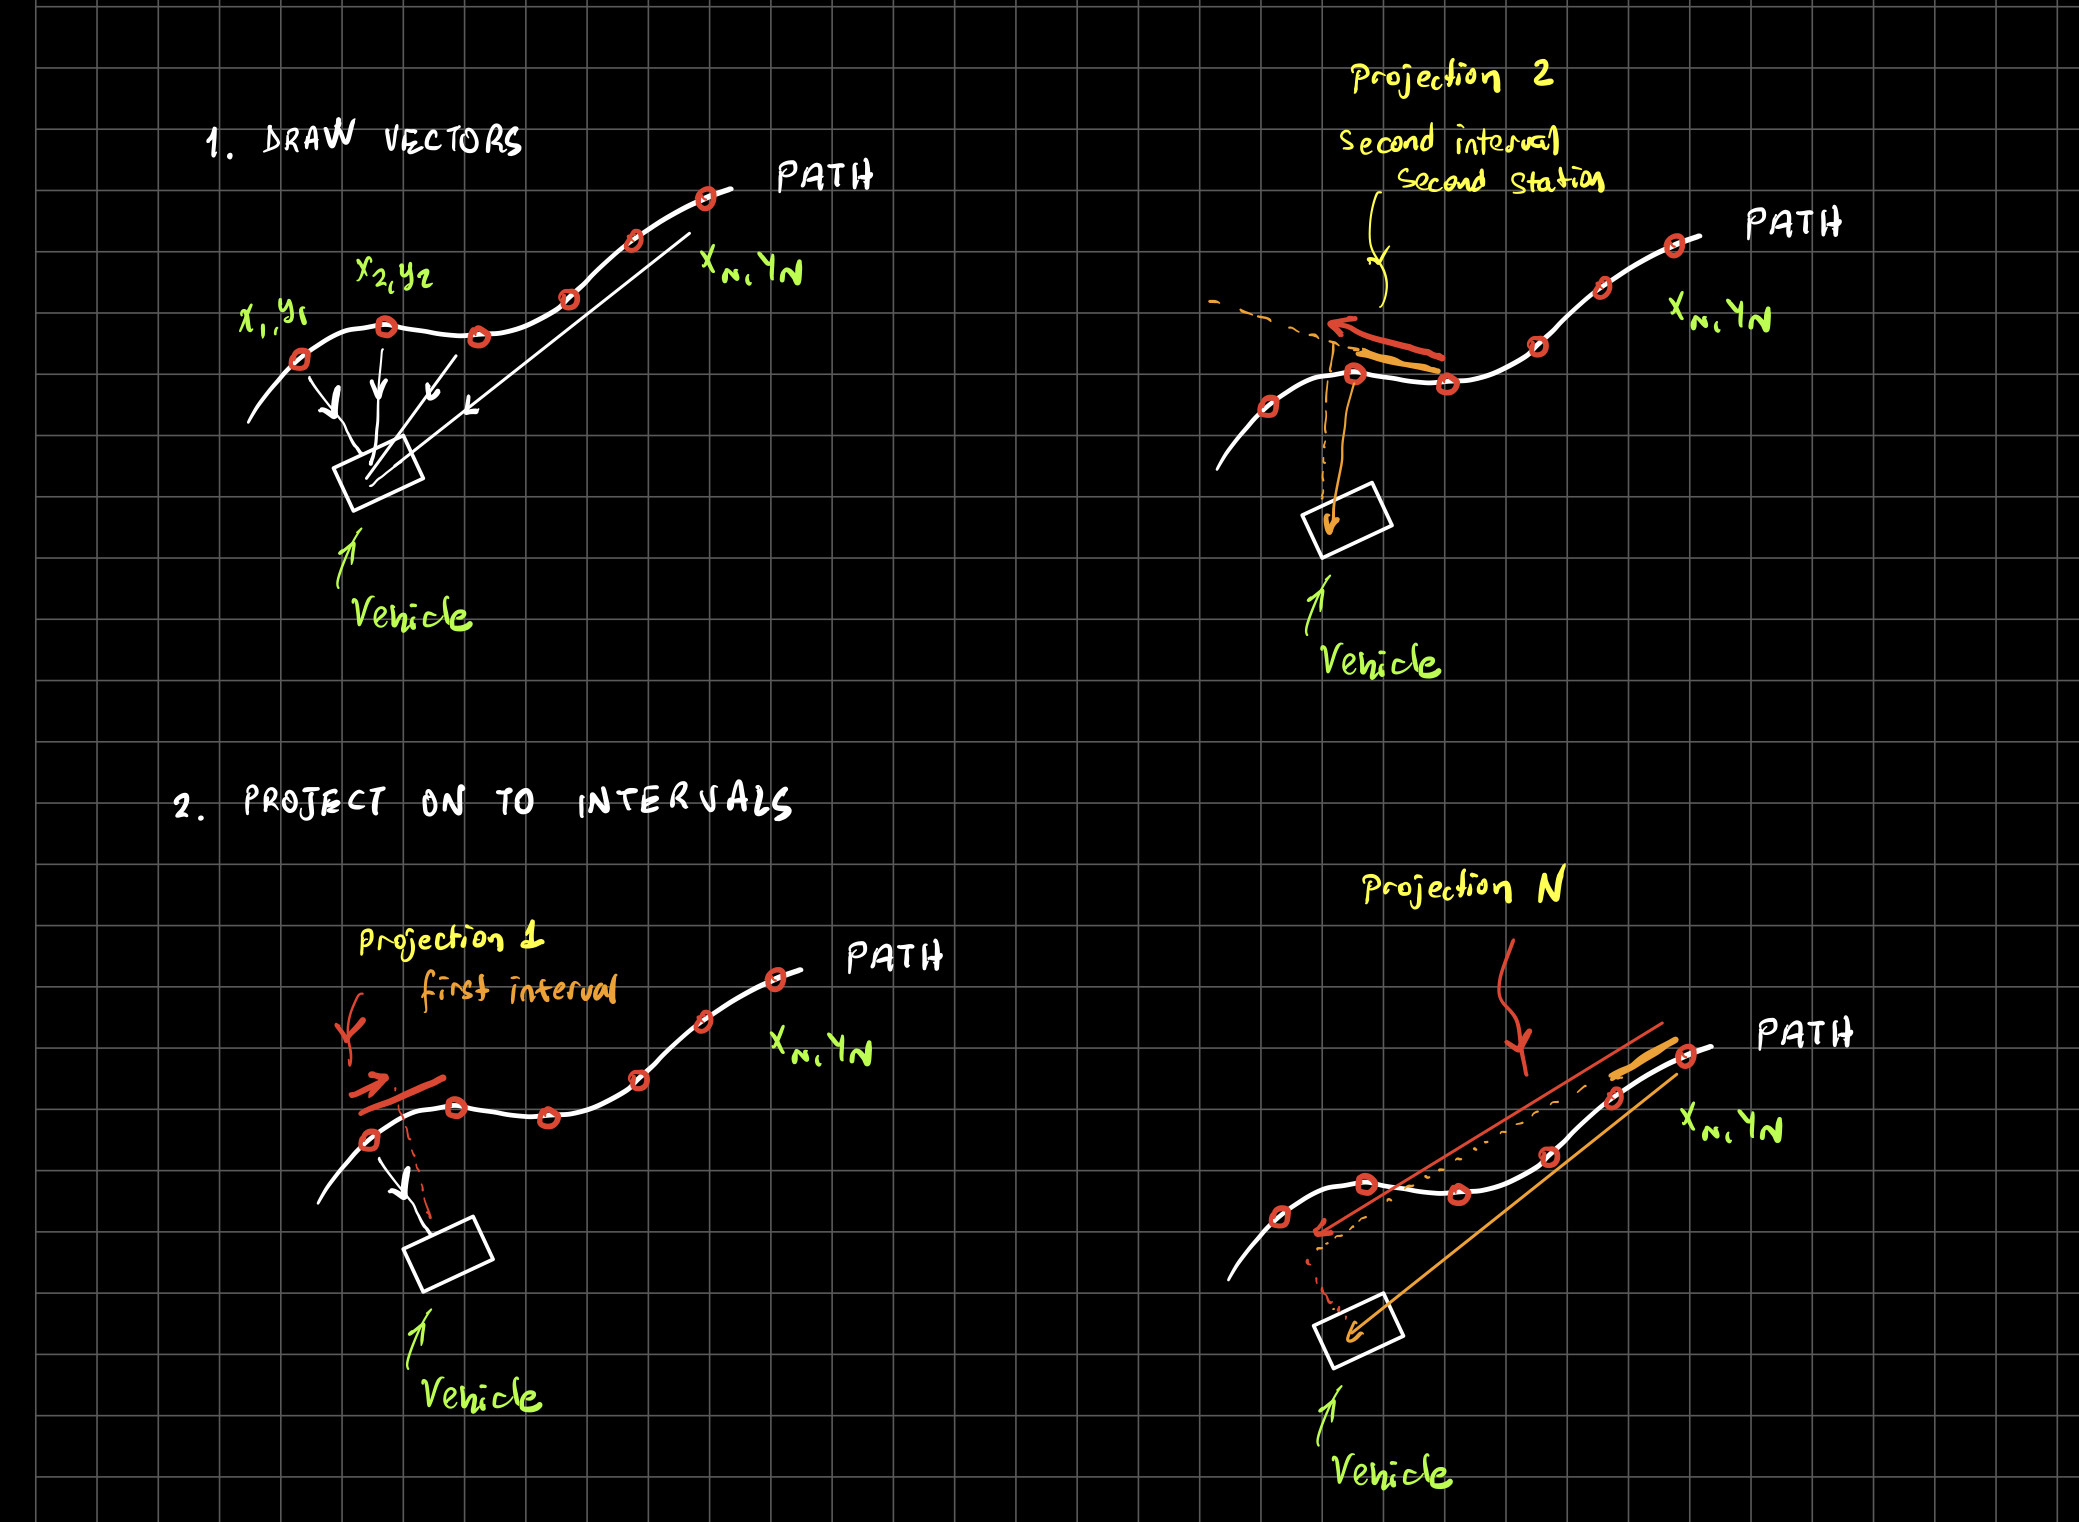

In [4]:
Image(filename=figpath+'fig_2.jpg')

As seen in the figure, except the first projection, all the projections drawn to the vehicle from the waypoints direct left. Only one projection direct opposite to the others. We can use this geometry to spot this projection using numpy broadcasting. The procedures are as follow:

- Define intervals as vectors; internal vectors bv = $s_2$ - $s_1$ where $s = [x, y]^T$  
- Define vectors to vehicle from the waypoints  av = all path x, y - vehicle x, y

Apply the vector projection [see](http://sites.science.oregonstate.edu/math/home/programs/undergrad/CalculusQuestStudyGuides/vcalc/dotprod/dotprod.html)

$$\operatorname{proj}_{a} \vec{b}=\frac{\vec{a} \cdot \vec{b}}{|\vec{a}|} \frac{\vec{a}}{|\vec{a}|}=\frac{\vec{a} \cdot \vec{b}}{|\vec{a}|^{2}} \vec{a}$$

In the following demonstration of the controller, we used this approach to compute the lateral and yaw deviation of the vehicle from the given reference path. After finding the shortest positive projection dS, we can use this value to interpolate for x and y coordinates on the given interval (point reference = p0 + p1* dS/S ). 

In [5]:
from __future__ import unicode_literals
import numpy as np
import numpy.matlib
import seaborn as sns
from collections import namedtuple
import matplotlib.pyplot as plt 

sns.set_style("darkgrid")

In [6]:
plt.rc('figure', figsize=(10, 6))

LABELSIZE = 14
plt.rc('axes', labelsize=LABELSIZE)
plt.rc('axes', titlesize=LABELSIZE)
plt.rc('figure', titlesize=LABELSIZE)
plt.rc('legend', fontsize=LABELSIZE)
plt.rc('xtick', labelsize=LABELSIZE)
plt.rc('ytick', labelsize=LABELSIZE)
plt.rc('axes', labelpad=18)

### Create a Path Object
We create a sinusoidal path and put some methods for the computation. We can offset the reference path given in any direction and compute the path parameters {x, y, heading angle, distance-s, curvature-kappa}. The curvature is computed using differential geometric methods. 

In [7]:
class Path():
    path_tuple = namedtuple('path', ['x', 'y', 'psi', 's', 'kappa'])
    
    def __init__(self):
        self.t = t = np.linspace(0, 200, 1000) # time paremetrization
        self.wt = 2*np.pi/self.t[-1]  # angular velocity
        self.aspan = 20 # meter of sinus height
        
        self.xt = self.t
        self.yt = self.aspan * np.sin(self.wt*self.t)
        
        ## derivatives
        self.dxt = 1
        self.dyt = self.aspan*self.wt*np.cos(self.wt*self.t)
        self.ds = np.hypot(self.dxt, self.dyt)
        
        self.s = np.cumsum(np.hypot(np.diff(self.xt), np.diff(self.dyt)))
        self.s = np.hstack((0, self.s))
        
        self.psi = np.arctan(self.dyt/self.dxt)
        self.psi[0:-1] = self.psi[1:] 
        self.kappa = -self.aspan * self.wt**2 * np.sin(self.wt*self.t)
        
        # offset curve to store
        self.offset_coord = self.offset(5)
        self.path_coord = self.path_mat()
        
    def path_mat(self):
        '''
            Path Matrix
            Returns of a matrix with the columns, x, y, psi, kappa
        '''
        path = self.path_tuple(x=self.xt[:, None], y=self.yt[:, None], 
                               psi=self.psi[:, None], s=self.s[:, None],
                               kappa=self.kappa[:, None])
        
        # self.path_coord = path 
        
        return(path)
         
    
    def plot(self):
        xt = self.xt
        yt = self.yt
        plt.plot(xt, yt)
        plt.plot(xt[0], yt[0], marker='s', label='Original Path')
        plt.plot(xt[-1], yt[-1], marker='s')
        
    
    def offset(self, doff):
        '''
            d is the offset distance, negative or positive
            created the curve features of the offset curves such as 
            s-distance, x, y, curvature-kappa and heading angle Ψ
            
        '''
        
        xdo = self.xt - doff*self.dyt/self.ds
        ydo = self.yt + doff*self.dxt/self.ds
        
        psio = np.arctan(np.diff(ydo)/np.diff(xdo))
        psio = np.hstack((psio, psio[-1]))
        
        s = np.cumsum(np.hypot(np.diff(xdo), np.diff(ydo)))
        s = np.hstack((0, s))
        
        kappa = self.kappa / (1 - self.kappa*doff)
        
        # Offset curve matrix
        path = self.path_tuple(x=xdo[:, None], y=ydo[:, None], 
                       psi=psio[:, None], s=s[:, None],
                       kappa=kappa)
        
        self.offset_coord = path
        
        return path
    
    def find_ind(self, x):
        '''
            Given x or s returns y and psi
        '''
        
        ind = np.where(self.xt>x)[0] 
         
        
        if len(ind):
            outcome = np.min(ind)
            
        else:
            outcome = len(self.xt)
        
        return outcome

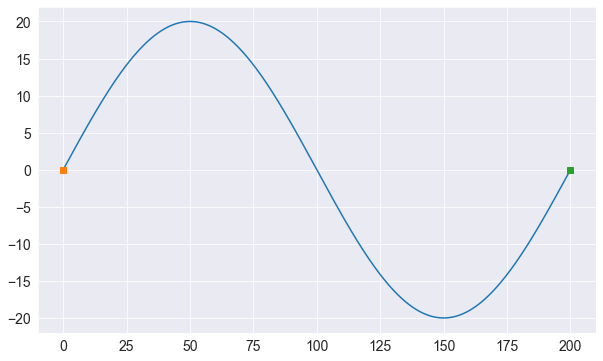

In [8]:
p1 = Path()
p1.plot()

In [9]:
p1.find_ind(x=250) # find the index of the given x-coordinate

1000

Text(0.5, 1.0, 'Source and Offset Curves')

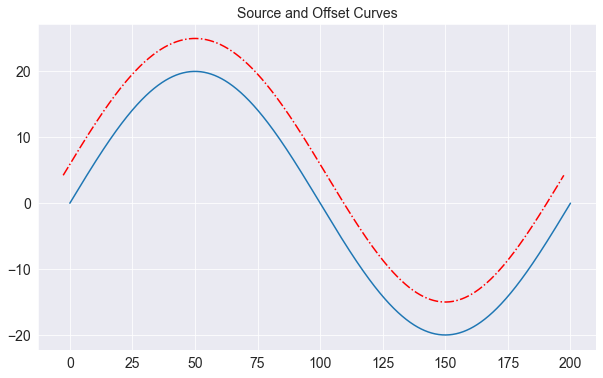

In [10]:
plt.plot(p1.xt, p1.yt)
plt.plot(p1.offset_coord.x, p1.offset_coord.y, 'r-.')
plt.title('Source and Offset Curves')


Text(0, 0.5, 'Curvature')

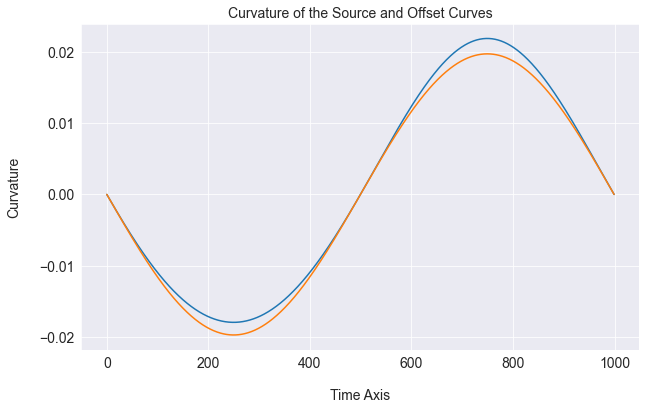

In [11]:
plt.plot(p1.offset_coord.kappa)
plt.plot(p1.kappa)
plt.title('Curvature of the Source and Offset Curves')
plt.xlabel('Time Axis')
plt.ylabel('Curvature')

### We have a path object which generates the related path features required for control applications
We can use this path object to generate an offset curve with the computed features including the new curvature as in shown in the figure above.

In the proceeding cells, we will create cars that follow the created path profile. First the kinematic controller. 

In [12]:
class controller():
    def __init__(self, path_object, offset=0):
        
        self.path = path_object
        
        if offset==0:
            
            self.x = self.path.path_coord.x
            self.y = self.path.path_coord.y
            self.path_xy = np.hstack((self.path.path_coord.x, self.path.path_coord.y))
            self.curvature = self.path.kappa
            self.s_dist = self.path.s
            self.psi = self.path.psi
        
        else:
            self.path.offset(offset)
            print('Offset it')
            self.x = self.path.offset_coord.x
            self.y = self.path.offset_coord.y
            self.path_xy = np.hstack((self.path.offset_coord.x, self.path.offset_coord.y))
            
            self.curvature = self.path.offset_coord.kappa
            self.s_dist = self.path.offset_coord.s
            self.psi = self.path.offset_coord.psi.flatten()
        
        ## LANE Tracking Control Parameters for Kinematic Vehicle
        # K_kin_ey and K_kin_epsi are parametrized with respect to Vxmin = 1 and Vxmax = 14
        self.K_kin_ey_0, self.K_kin_ey_1 = (0.43, 0.30)  # for Vmin_0 and Vmax_1 for interpolation the control
        self.K_kin_epsi_0, self.K_kin_epsi_1 = (1.61, 1.55)  # for Vmin_0 and Vmax_1

        # these are minimum values of the kinematic tracking controller coefficients
        self.K_kin_ey = self.K_kin_ey_0  # current lateral deviation control coefficient
        self.K_kin_epsi = self.K_kin_epsi_0  # current heading angle deviation

        # Velocity min max mapping onto [0, 1]
        self.kinematic_speed_max = 14  # m/s maximum speed that the kinematic controller can work at
        self.kinematic_speed_min = 1
        self.linear_vel_coeff = lambda V: (V - self.kinematic_speed_min) / (
                self.kinematic_speed_max - self.kinematic_speed_min) if V>=1 else 0.0  # to interpolate the control, see the notebook

        self.interp_kin_cont = lambda λ_vel, k0, k1: k0 + λ_vel * (k1 - k0)  
        
        # reach the destination
        self.exit_status = False
        
        # keep last computed error
        self.errors = [0]*2
        
        # keep s-coordinate
        self.current_s = 0 
        
    def control_signal(self, Vg):
        '''
            Given Speed - Vg, returns the steering control signal
        '''
        
        lambda_velocity = self.linear_vel_coeff(Vg)

        k_ey =  self.interp_kin_cont(lambda_velocity, self.K_kin_ey_0, self.K_kin_ey_1)
        k_epsi = self.interp_kin_cont(lambda_velocity, self.K_kin_epsi_0, self.K_kin_epsi_1)
        
        return k_ey, k_epsi
        
        
    
    def locate_car(self, car_xyψ):
        '''
            Car position is a numpy array of Rx[1, 3] two columns 1 row
        
        '''
        
                
        car_xy = car_xyψ[0, :2][None, :]
        
        av = car_xy - self.path_xy[:-1]
        bv = np.diff(self.path_xy, axis=0)
        
        abs_bv = np.linalg.norm(bv, axis=1)  # magnitute of the path section
        delta_S = (av * bv).sum(axis=1) / abs_bv  # from s0 towards s1

        if delta_S[0] < 0:
            delta_S[0] = 0
            
        ## Target Global Points on the Global
        '''
            The current coordinates Xv, Yv of the vehicle are projected on the all the line intervals of the path
            the resultant projection vector consists of distances to the starting point of the lines point-0. 
            If the projection distance is negative, the points are ahead of the car's global location, else 
            behind the car's current location. We take the closest point as the smallest positive distance here 
        '''
        current_station_ind = np.argmin(delta_S[delta_S >= 0])
#         print('Current Station Ind : {} out of {}'.format(current_station_ind, len(delta_S)))

        delta_S0 = delta_S[current_station_ind]  # How much the car is away from the station 0

        # Get station-0 and station-1 coordinates from the path in between the car is located
        Xstation_0, Ystation_0 = self.path_xy[current_station_ind, :]
        Psi_s0 = self.psi[current_station_ind]
        Kappa_s0 = self.curvature[current_station_ind]
        
        # Keep s-coordinate
        s0 = self.s_dist[current_station_ind]
        

        if current_station_ind<len(delta_S)-2:
            Xstation_1, Ystation_1 = self.path_xy[current_station_ind+1, :]
            Psi_s1 = self.psi[current_station_ind+1]
            Kappa_s1 = self.curvature[current_station_ind + 1]
            s1 = self.s_dist[current_station_ind + 1]


        else:
            # take the last point of the path
            Xstation_1, Ystation_1 = self.path_xy[-1, :]
            Psi_s1 = self.psi[-1]
            Kappa_s1 = self.curvature[-1]
            s1 = self.s_dist[-1]
            
            self.exit_status = True

      

        # Current Car Coordinates Xv, Yv
        Xv, Yv = car_xy[0]
        Psi_v = car_xyψ[0, -1]
#         print('Psi_v {}'.format(Psi_v))


        # Apply linear interpolation
        hyp_of_interval = np.hypot(Xstation_1-Xstation_0, Ystation_1-Ystation_0)
        ratio = delta_S0 / hyp_of_interval
        
#         print('Ratio {}'.format(ratio))

        Xref = Xstation_0 + ratio * (Xstation_1 - Xstation_0)
        Yref = Ystation_0 + ratio * (Ystation_1 - Ystation_0)
        Psi_ref = Psi_s0 + ratio * (Psi_s1 - Psi_s0)
        Kappa_ref = Kappa_s0 + ratio * (Kappa_s1 - Kappa_s0)
        sref = s0 + ratio*(s1 - s0)

        # Generate tracking errors
        e_y = (Yref-Yv)*np.cos(Psi_ref) - (Xref - Xv) * np.sin(Psi_ref)
#         print('e_y {}'.format(e_y))
        
        e_psi = Psi_ref - Psi_v
#         print('e_psi {}'.format(e_psi))

        e_y = e_y + 0 * e_psi

#         if e_y>0.2 or e_psi>np.rad2deg(10):
#             print('ey {} and epsi {}'.format(e_y, e_psi))

        
        # keep error states
        self.errors[0] = e_y
        self.errors[1] = e_psi
        #print(self.errors[0])
        
        # keep current s coordinate
        self.current_s = sref
        
        return e_y, e_psi, Kappa_ref

        
        

In [13]:

class car_model():
    # vehicle parameters
    vehicle_params = recordtype('control_params', 'mass Iz L Lf Lr Cf Cr')
    
    # vehicle states
    vehicle_states = recordtype('states', 'Xw  Yw Psi Vx, Vy Psi_dot')
   
    
    def __init__(self, controller, Xw0 = 0,  Vx0 = 0):
        
        self.controller = controller 
        self.time = 0.0
        self.dt = 0.1
        self.s0 = 0
        self.wt = 2*np.pi/5  # angular velocity for variable speed
        
        # Get Initial States from the Path         
        #self.current_control_state = [0]*6 # Xw. Yw. Psi, Vx, Vy, Psi_dot
        self.current_control_state = self.vehicle_states(Xw=0, Yw=0, Psi=0, Vx=0, Vy=0, Psi_dot = 0)
        
        if Xw0 == 0:
            self.current_control_state.Xw = self.controller.path.path_coord.x[0, 0]
            
            initial_ey = np.random.rand(1)[0]*5
            initial_epsi = np.random.rand(1)[0]*0.2
            
            self.current_control_state.Yw += initial_ey
            self.current_control_state.Psi += initial_epsi
        
        else:
            self.current_control_state.Xw = Xw0
            ind = self.controller.path.find_ind(Xw0)
            print('ind ', ind)
            
            initial_ey = np.random.rand(1)[0]*5
            initial_epsi = np.random.rand(1)[0]*0.2
            
            self.current_control_state.Yw = self.controller.y[ind][0] + initial_ey
            self.current_control_state.Psi = self.controller.psi[ind] +  initial_epsi
            self.s0 = self.controller.s_dist[ind] 
        
        self.current_control_state.Vx = Vx0
 
        
        ## control signals
        self.current_control_gas = 0.0
        self.current_control_steering = 0.0

        self.prev_control_gas = 0.0
        self.prev_control_steering = 0.0
        
        # Vehicle Parameters
        self.vehicle_params = self.vehicle_params(mass=1900, Iz= 1900*1.5*1.4, L=2.91, Lf=1.5,
                                                  Lr=1.41, Cf=None, Cr=None)
        
        # keep error values
        self.ey = initial_ey
        self.epsi = initial_epsi 
         
        self.Lr = self.vehicle_params.Lr
        self.L = self.vehicle_params.L
        
        # keep state and control history
        self.state_history = {'Xw':[Xw0], 'Yw':[self.current_control_state.Yw], 
                              'Psi':[self.current_control_state.Psi], 'Vx':[Vx0], 
                              'Vy':[0], 'Psidot':[0], 'delta':[0], 'ey':[0], 'epsi':[0], 's':[self.s0], 't':[0]}
        
        
    def rotate_world2body(self, x, y, psi):
        xnew = np.cos(psi) * x + np.sin(psi) * y
        ynew = -np.sin(psi) * x + np.cos(psi) * y

        return xnew, ynew

    def rotate_body2world(self, x, y, psi):
        xnew = np.cos(psi) * x - np.sin(psi) * y
        ynew = np.sin(psi) * x + np.cos(psi) * y

        return xnew, ynew
    
    def slip_model(self):
        # Get the current control state
        Xw, Yw, Psi, Vx, Vy, Psi_dot = self.current_control_state
        
        # Compute next states
        # Vg = control_acceleration * self.dt + np.hypot(Vx, Vy)
        
        Vg = np.hypot(Vx, Vy) + 0.3*np.sin(self.wt*self.time)
        beta = np.arctan((self.Lr / self.L) * np.tan(self.current_control_steering))
        
        
        Vx_w = Vg * np.cos(Psi + beta)
        Vy_w = Vg * np.sin(Psi + beta)
        Psi_dot = Vg * np.sin(beta) / self.Lr

        Xw_next = Xw + Vx_w * self.dt
        Yw_next = Yw + Vy_w * self.dt
        Psi_next = Psi + Psi_dot * self.dt

        Vx_next, Vy_next = self.rotate_world2body(Vx_w, Vy_w, Psi) # Body frame velocities



        self.current_control_state = self.vehicle_states(Xw=Xw_next, Yw=Yw_next, Psi=Psi_next, Vx=Vx_next,
                                                         Vy=Vy_next, Psi_dot=Psi_dot)  
        
        return Xw_next, Yw_next, Psi_next
   
    def step(self):
        
        car_xyψ = np.array(list(self.current_control_state)[0:3])[None, :]
        # int(car_xyψ)
        
        # locate car w.r.t the path
        e_y, e_psi, kappa_ref = self.controller.locate_car(car_xyψ)
        self.ey = e_y
        self.epsi = e_psi
        
        # interpolate control coefficients for the current longitudinal speed
        k_ey, k_epsi = self.controller.control_signal(self.current_control_state.Vx)
        
        
        
        # generate control signal based on the error
        # compute steering
        feed_forward_steering = np.arctan(kappa_ref * self.L)
        delta_steering = k_ey*e_y + k_epsi * e_psi + feed_forward_steering + np.random.rand(1)[0]*0.1
        
        # Update controllers
        self.prev_control_steering = self.current_control_steering
        self.current_control_steering = delta_steering
        
        # update the history
        self.update_history()
        
        # step the model
        next_states = self.slip_model()
        
        
#         print('Errors {} - {}'.format(e_y, e_psi))
        return next_states

    
    def update_history(self):
        self.time += self.dt
        self.state_history['Xw'].append(self.current_control_state.Xw)
        self.state_history['Yw'].append(self.current_control_state.Yw)
        self.state_history['Psi'].append(self.current_control_state.Psi)
        self.state_history['Vx'].append(self.current_control_state.Vx)
        self.state_history['Vy'].append(self.current_control_state.Vy)
        self.state_history['Psidot'].append(self.current_control_state.Psi_dot)
        self.state_history['delta'].append(self.current_control_steering)
        
        # error
        self.state_history['ey'].append(self.ey)
        self.state_history['epsi'].append(self.epsi)
        
        self.state_history['s'].append(self.controller.current_s)
        self.state_history['t'].append(self.time)
        
        

### Create a steering controller with a pre-defined path and assign it to a car model object


In [14]:
c1 = controller(p1) # a controller to which p1 path is assigned
c2 = controller(p1, offset=-2.8) # another controller assigned a path which is an offset of p1
c1.psi.shape, c2.psi.shape 


Offset it


((1000,), (1000,))

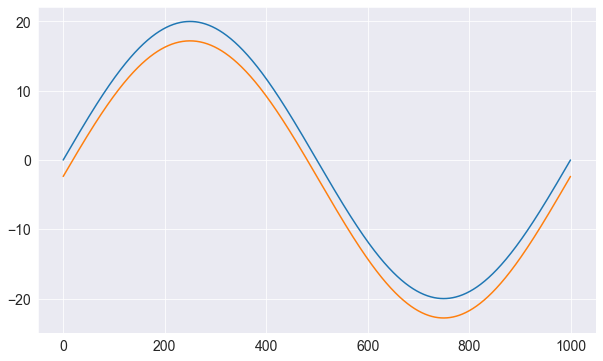

In [15]:
plt.plot(c1.path.path_coord.y)
plt.plot(c2.path.offset_coord.y)

### Create a car model object, with the controller object passed

In [16]:
v1 = car_model(c1, Xw0=5, Vx0=2) # a car model whose initial position Xw0 and velocity is defined 
v2 = car_model(c2, Xw0=50, Vx0=25) 

ind  25
ind  250


### Simulate step by step the car 

In [17]:
simulate = True
while simulate:
    
    if not v1.controller.exit_status:
        snext1 = v1.step()
    
    if not v2.controller.exit_status:
        snext2 = v2.step()
        
    if (v1.controller.exit_status and v2.controller.exit_status):
        simulate = False

### Plot the trajectories

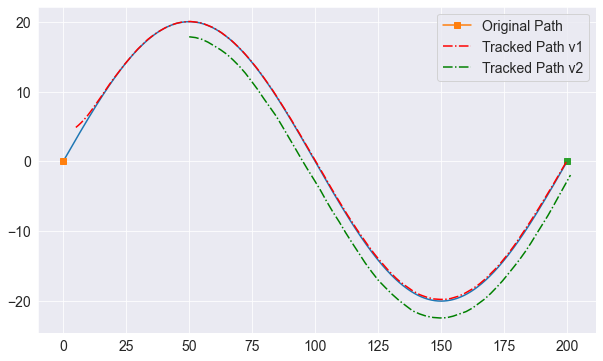

In [18]:
p1.plot() 
plt.plot(v1.state_history['Xw'], v1.state_history['Yw'], 'r-.', label='Tracked Path v1')
plt.plot(v2.state_history['Xw'], v2.state_history['Yw'], 'g-.', label='Tracked Path v2') # tracking an offset
plt.legend()